In [58]:
import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import files
from google.colab import drive

In [59]:
drive.mount('/content/drive')
_PATH_FOLDER_OUT = '/content/drive/MyDrive/results_simulation/'
_PATH_FOLDER_IN = '/content/drive/MyDrive/input_model/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)
assert num_gpus_available > 0

Num GPUs Available:  1


In [61]:
!pip install transformers

In [62]:
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification


In [63]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures


tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [65]:
def f_load_data():
    df = pd.read_csv(_PATH_FOLDER_IN + 'df_agg.csv', sep = ';')
    df['short_review'] = df['text']
    df['short_review'] = df['short_review'].str.lower()
    df = df[["short_review", "Sentiment"]]
    return df


In [66]:

def f_save_df(df_save, file_name_in):
  df_save.to_csv( _PATH_FOLDER_OUT +  '/' + file_name_in + ".csv", sep=';', index= False)


In [67]:
def f_train_model(df_in):
    reviews = df_in['short_review'].values.tolist()
    labels = df_in['Sentiment'].tolist()
    training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(reviews, labels, test_size=.10)
    tokenizer([training_sentences[0]], truncation=True,
                            padding=True, max_length=1024)
    

    train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True)
    val_encodings = tokenizer(validation_sentences,
                                truncation=True,
                                padding=True)
    
    train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
        training_labels
    ))

    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        validation_labels
    ))

    #model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])
    model.fit(train_dataset.shuffle(100).batch(2),
            epochs=2,
            batch_size=2)
    # model.fit(train_dataset.shuffle(150).batch(2),
    #         epochs=2,
    #         batch_size=16,
    #         validation_data = val_dataset.shuffle(150).batch(2))
    # model.save_pretrained("./sentiment")
    # loaded_model = TFDistilBertForSequenceClassification.from_pretrained("./sentiment")
    return model


In [68]:
def f_get_prediction(model_in, df_in):


    text_tmp = df_in['short_review'].iloc[-1]
    sent_tmp = df_in['Sentiment'].iloc[-1]
    predict_input = tokenizer.encode(text_tmp,
                                    truncation=True,
                                    padding=True,
                                    return_tensors="tf")

    tf_output = model_in.predict(predict_input)[0]


    tf_prediction = tf.nn.softmax(tf_output, axis=1)
    labels = [0,1]
    label = tf.argmax(tf_prediction, axis=1)
    label = label.numpy()
    pred_tmp = labels[label[0]]
    print('sentiment: ' + str(sent_tmp) + ' pred: ' + str(pred_tmp))
    return pred_tmp

In [69]:
# df['Prediction'] = 0
# for index, row in df.iterrows():
#     #print(row['short_review'], row['Sentiment'])
#     #print(df.loc[index,'Sentiment'])
#     text_tmp = row['short_review']
#     sent_tmp = row['Sentiment']
#     predict_input = tokenizer.encode(text_tmp,
#                                     truncation=True,
#                                     padding=True,
#                                     return_tensors="tf")

#     tf_output = loaded_model.predict(predict_input)[0]


#     tf_prediction = tf.nn.softmax(tf_output, axis=1)
#     labels = [0,1]
#     label = tf.argmax(tf_prediction, axis=1)
#     label = label.numpy()
#     pred_tmp = labels[label[0]]
#     df.loc[index,'Prediction'] = pred_tmp
#     print('sentiment: ' + str(sent_tmp) + ' pred: ' + str(pred_tmp))

In [70]:
df_data = f_load_data()
df_agg = df_data.copy()
df_agg['Prediction'] = 0
index_lst = df_data.index 
for index_tmp in index_lst[20:]:
    print('index_tmp: ' + str(index_tmp) + '/' + str(index_lst[-1]))
    df_tmp = df_data[:index_tmp]
    df_train = df_data[:index_tmp-1]
    model_tmp = f_train_model(df_train)
    pred_tmp = f_get_prediction(model_tmp, df_tmp)
    df_agg.loc[index_tmp,'Prediction'] = pred_tmp
    del model_tmp
    tf.keras.backend.clear_session()
    filename_out = '_out_' + str(index_tmp)
    f_save_df(df_agg, filename_out)

index_tmp: 20/198


Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
9/9 [==============================] - 17s 397ms/step - loss: 0.2824 - accuracy: 1.0000
Epoch 2/2
9/9 [==============================] - 4s 396ms/step - loss: 0.0426 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 22/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
9/9 [==============================] - 17s 396ms/step - loss: 0.2449 - accuracy: 1.0000
Epoch 2/2
9/9 [==============================] - 4s 397ms/step - loss: 0.0352 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 23/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
10/10 [==============================] - 18s 378ms/step - loss: 0.4348 - accuracy: 0.9474
Epoch 2/2
10/10 [==============================] - 4s 380ms/step - loss: 0.0426 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 24/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
10/10 [==============================] - 18s 394ms/step - loss: 0.2898 - accuracy: 0.8500
Epoch 2/2
10/10 [==============================] - 4s 395ms/step - loss: 0.0269 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 25/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
11/11 [==============================] - 18s 379ms/step - loss: 0.2954 - accuracy: 0.9048
Epoch 2/2
11/11 [==============================] - 4s 380ms/step - loss: 0.0338 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 26/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
11/11 [==============================] - 18s 395ms/step - loss: 0.3290 - accuracy: 0.8636
Epoch 2/2
11/11 [==============================] - 4s 395ms/step - loss: 0.0203 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 27/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
12/12 [==============================] - 19s 381ms/step - loss: 0.2881 - accuracy: 0.9130
Epoch 2/2
12/12 [==============================] - 5s 381ms/step - loss: 0.0279 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 28/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
12/12 [==============================] - 19s 395ms/step - loss: 0.2187 - accuracy: 0.9167
Epoch 2/2
12/12 [==============================] - 5s 396ms/step - loss: 0.0220 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 29/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
13/13 [==============================] - 19s 382ms/step - loss: 0.3783 - accuracy: 0.8400
Epoch 2/2
13/13 [==============================] - 5s 383ms/step - loss: 0.0612 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 30/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
13/13 [==============================] - 19s 396ms/step - loss: 0.2069 - accuracy: 0.9231
Epoch 2/2
13/13 [==============================] - 5s 397ms/step - loss: 0.0170 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 31/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
14/14 [==============================] - 19s 383ms/step - loss: 0.2080 - accuracy: 0.9630
Epoch 2/2
14/14 [==============================] - 5s 382ms/step - loss: 0.0095 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 32/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
14/14 [==============================] - 20s 385ms/step - loss: 0.2860 - accuracy: 0.9259
Epoch 2/2
14/14 [==============================] - 5s 383ms/step - loss: 0.0237 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 33/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
14/14 [==============================] - 19s 396ms/step - loss: 0.2718 - accuracy: 0.8929
Epoch 2/2
14/14 [==============================] - 6s 397ms/step - loss: 0.0104 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 34/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
15/15 [==============================] - 19s 384ms/step - loss: 0.2689 - accuracy: 0.9310
Epoch 2/2
15/15 [==============================] - 6s 383ms/step - loss: 0.0560 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 35/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
15/15 [==============================] - 20s 397ms/step - loss: 0.2243 - accuracy: 0.9333
Epoch 2/2
15/15 [==============================] - 6s 395ms/step - loss: 0.0112 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 36/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
16/16 [==============================] - 20s 386ms/step - loss: 0.2367 - accuracy: 0.9355
Epoch 2/2
16/16 [==============================] - 6s 384ms/step - loss: 0.0118 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 37/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
16/16 [==============================] - 20s 396ms/step - loss: 0.2415 - accuracy: 0.8438
Epoch 2/2
16/16 [==============================] - 6s 395ms/step - loss: 0.0062 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 38/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
17/17 [==============================] - 20s 386ms/step - loss: 0.2661 - accuracy: 0.9394
Epoch 2/2
17/17 [==============================] - 7s 385ms/step - loss: 0.0108 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 39/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
17/17 [==============================] - 21s 396ms/step - loss: 0.1274 - accuracy: 1.0000
Epoch 2/2
17/17 [==============================] - 7s 396ms/step - loss: 0.0089 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 40/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
18/18 [==============================] - 21s 386ms/step - loss: 0.1884 - accuracy: 0.9429
Epoch 2/2
18/18 [==============================] - 7s 387ms/step - loss: 0.0061 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 41/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
18/18 [==============================] - 21s 396ms/step - loss: 0.2556 - accuracy: 0.8889
Epoch 2/2
18/18 [==============================] - 7s 397ms/step - loss: 0.0091 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 42/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
18/18 [==============================] - 21s 397ms/step - loss: 0.2253 - accuracy: 0.9722
Epoch 2/2
18/18 [==============================] - 7s 397ms/step - loss: 0.0140 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 43/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
19/19 [==============================] - 21s 388ms/step - loss: 0.1647 - accuracy: 0.9459
Epoch 2/2
19/19 [==============================] - 7s 388ms/step - loss: 0.0132 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 44/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
19/19 [==============================] - 22s 396ms/step - loss: 0.1447 - accuracy: 1.0000
Epoch 2/2
19/19 [==============================] - 7s 395ms/step - loss: 0.0064 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 45/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
20/20 [==============================] - 22s 388ms/step - loss: 0.0978 - accuracy: 1.0000
Epoch 2/2
20/20 [==============================] - 8s 387ms/step - loss: 0.0033 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 46/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
20/20 [==============================] - 22s 397ms/step - loss: 0.1079 - accuracy: 1.0000
Epoch 2/2
20/20 [==============================] - 8s 397ms/step - loss: 0.0052 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 47/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
21/21 [==============================] - 23s 390ms/step - loss: 0.0807 - accuracy: 1.0000
Epoch 2/2
21/21 [==============================] - 8s 390ms/step - loss: 0.0027 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 48/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
21/21 [==============================] - 23s 397ms/step - loss: 0.1138 - accuracy: 1.0000
Epoch 2/2
21/21 [==============================] - 8s 397ms/step - loss: 0.0057 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 49/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
22/22 [==============================] - 23s 391ms/step - loss: 0.1419 - accuracy: 0.9302
Epoch 2/2
22/22 [==============================] - 9s 391ms/step - loss: 0.0045 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 50/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
22/22 [==============================] - 24s 399ms/step - loss: 0.1404 - accuracy: 0.9773
Epoch 2/2
22/22 [==============================] - 9s 397ms/step - loss: 0.0063 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 51/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
23/23 [==============================] - 23s 390ms/step - loss: 0.1049 - accuracy: 0.9778
Epoch 2/2
23/23 [==============================] - 9s 390ms/step - loss: 0.0042 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 52/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
23/23 [==============================] - 23s 391ms/step - loss: 0.1374 - accuracy: 0.9778
Epoch 2/2
23/23 [==============================] - 9s 390ms/step - loss: 0.0037 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 53/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
23/23 [==============================] - 23s 397ms/step - loss: 0.0980 - accuracy: 1.0000
Epoch 2/2
23/23 [==============================] - 9s 398ms/step - loss: 0.0037 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 54/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
24/24 [==============================] - 23s 391ms/step - loss: 0.1705 - accuracy: 0.9787
Epoch 2/2
24/24 [==============================] - 9s 390ms/step - loss: 0.0048 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 55/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
24/24 [==============================] - 24s 397ms/step - loss: 0.1790 - accuracy: 0.9792
Epoch 2/2
24/24 [==============================] - 10s 396ms/step - loss: 0.0036 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 56/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
25/25 [==============================] - 24s 391ms/step - loss: 0.1817 - accuracy: 0.9388
Epoch 2/2
25/25 [==============================] - 10s 390ms/step - loss: 0.0041 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 57/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
25/25 [==============================] - 24s 396ms/step - loss: 0.1016 - accuracy: 1.0000
Epoch 2/2
25/25 [==============================] - 10s 397ms/step - loss: 0.0023 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 58/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
26/26 [==============================] - 24s 390ms/step - loss: 0.1472 - accuracy: 1.0000
Epoch 2/2
26/26 [==============================] - 10s 391ms/step - loss: 0.0035 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 59/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
26/26 [==============================] - 24s 398ms/step - loss: 0.0922 - accuracy: 1.0000
Epoch 2/2
26/26 [==============================] - 10s 398ms/step - loss: 0.0039 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 60/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
27/27 [==============================] - 24s 392ms/step - loss: 0.1219 - accuracy: 0.9811
Epoch 2/2
27/27 [==============================] - 11s 391ms/step - loss: 0.0035 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 61/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
27/27 [==============================] - 24s 399ms/step - loss: 0.0912 - accuracy: 1.0000
Epoch 2/2
27/27 [==============================] - 11s 397ms/step - loss: 0.0036 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 62/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
27/27 [==============================] - 25s 398ms/step - loss: 0.1016 - accuracy: 0.9630
Epoch 2/2
27/27 [==============================] - 11s 397ms/step - loss: 0.0029 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 63/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
28/28 [==============================] - 25s 392ms/step - loss: 0.1082 - accuracy: 1.0000
Epoch 2/2
28/28 [==============================] - 11s 391ms/step - loss: 0.0018 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 64/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
28/28 [==============================] - 25s 397ms/step - loss: 0.1138 - accuracy: 1.0000
Epoch 2/2
28/28 [==============================] - 11s 397ms/step - loss: 0.0024 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 65/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
29/29 [==============================] - 25s 390ms/step - loss: 0.1794 - accuracy: 0.8947
Epoch 2/2
29/29 [==============================] - 11s 391ms/step - loss: 0.0045 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 66/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
29/29 [==============================] - 26s 398ms/step - loss: 0.1128 - accuracy: 0.9655
Epoch 2/2
29/29 [==============================] - 11s 397ms/step - loss: 0.0029 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 67/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
30/30 [==============================] - 26s 392ms/step - loss: 0.1444 - accuracy: 0.9322
Epoch 2/2
30/30 [==============================] - 12s 393ms/step - loss: 0.0021 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 68/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
30/30 [==============================] - 26s 398ms/step - loss: 0.1155 - accuracy: 0.9667
Epoch 2/2
30/30 [==============================] - 12s 397ms/step - loss: 0.0035 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 69/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
31/31 [==============================] - 26s 393ms/step - loss: 0.1033 - accuracy: 0.9672
Epoch 2/2
31/31 [==============================] - 12s 392ms/step - loss: 0.0026 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 70/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
31/31 [==============================] - 26s 398ms/step - loss: 0.1284 - accuracy: 0.9839
Epoch 2/2
31/31 [==============================] - 12s 397ms/step - loss: 0.0024 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 71/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
32/32 [==============================] - 27s 392ms/step - loss: 0.1419 - accuracy: 0.9683
Epoch 2/2
32/32 [==============================] - 13s 393ms/step - loss: 0.0029 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 72/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
32/32 [==============================] - 27s 392ms/step - loss: 0.0595 - accuracy: 1.0000
Epoch 2/2
32/32 [==============================] - 13s 392ms/step - loss: 0.0015 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 73/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
32/32 [==============================] - 27s 398ms/step - loss: 0.0622 - accuracy: 1.0000
Epoch 2/2
32/32 [==============================] - 13s 397ms/step - loss: 0.0019 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 74/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
33/33 [==============================] - 27s 393ms/step - loss: 0.1376 - accuracy: 0.8923
Epoch 2/2
33/33 [==============================] - 13s 392ms/step - loss: 0.0019 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 75/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
33/33 [==============================] - 26s 397ms/step - loss: 0.0985 - accuracy: 1.0000
Epoch 2/2
33/33 [==============================] - 13s 398ms/step - loss: 0.0030 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 76/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
34/34 [==============================] - 27s 393ms/step - loss: 0.1498 - accuracy: 0.9552
Epoch 2/2
34/34 [==============================] - 13s 392ms/step - loss: 0.0052 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 77/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
34/34 [==============================] - 27s 398ms/step - loss: 0.0901 - accuracy: 0.9559
Epoch 2/2
34/34 [==============================] - 14s 398ms/step - loss: 0.0019 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 78/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
35/35 [==============================] - 28s 393ms/step - loss: 0.0407 - accuracy: 1.0000
Epoch 2/2
35/35 [==============================] - 14s 392ms/step - loss: 0.0010 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 79/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
35/35 [==============================] - 28s 398ms/step - loss: 0.1311 - accuracy: 0.9571
Epoch 2/2
35/35 [==============================] - 14s 398ms/step - loss: 0.0053 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 80/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
36/36 [==============================] - 28s 393ms/step - loss: 0.1051 - accuracy: 0.9577
Epoch 2/2
36/36 [==============================] - 14s 393ms/step - loss: 0.0013 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 81/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
36/36 [==============================] - 28s 397ms/step - loss: 0.1357 - accuracy: 0.9583
Epoch 2/2
36/36 [==============================] - 14s 398ms/step - loss: 0.0022 - accuracy: 1.0000
sentiment: 1.0 pred: 1
index_tmp: 82/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
36/36 [==============================] - 28s 398ms/step - loss: 0.0953 - accuracy: 0.9722
Epoch 2/2
36/36 [==============================] - 14s 398ms/step - loss: 0.0037 - accuracy: 1.0000
sentiment: 0.0 pred: 1
index_tmp: 83/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
37/37 [==============================] - 29s 393ms/step - loss: 0.1615 - accuracy: 0.9726
Epoch 2/2
37/37 [==============================] - 15s 393ms/step - loss: 0.0885 - accuracy: 0.9863
sentiment: 0.0 pred: 1
index_tmp: 84/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
37/37 [==============================] - 29s 397ms/step - loss: 0.2129 - accuracy: 0.9595
Epoch 2/2
37/37 [==============================] - 15s 397ms/step - loss: 0.1482 - accuracy: 0.9730
sentiment: 0.0 pred: 1
index_tmp: 85/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
38/38 [==============================] - 29s 393ms/step - loss: 0.1737 - accuracy: 0.9600
Epoch 2/2
38/38 [==============================] - 15s 393ms/step - loss: 0.1200 - accuracy: 0.9733
sentiment: 0.0 pred: 1
index_tmp: 86/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
38/38 [==============================] - 29s 398ms/step - loss: 0.2590 - accuracy: 0.9079
Epoch 2/2
38/38 [==============================] - 15s 399ms/step - loss: 0.2049 - accuracy: 0.9474
sentiment: 1.0 pred: 1
index_tmp: 87/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
39/39 [==============================] - 29s 395ms/step - loss: 0.2608 - accuracy: 0.9481
Epoch 2/2
39/39 [==============================] - 15s 395ms/step - loss: 0.1638 - accuracy: 0.9091
sentiment: 1.0 pred: 1
index_tmp: 88/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
39/39 [==============================] - 29s 399ms/step - loss: 0.2756 - accuracy: 0.9103
Epoch 2/2
39/39 [==============================] - 16s 398ms/step - loss: 0.1470 - accuracy: 0.9487
sentiment: 0.0 pred: 1
index_tmp: 89/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
40/40 [==============================] - 30s 395ms/step - loss: 0.3012 - accuracy: 0.9241
Epoch 2/2
40/40 [==============================] - 16s 394ms/step - loss: 0.2197 - accuracy: 0.9494
sentiment: 1.0 pred: 1
index_tmp: 90/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
40/40 [==============================] - 30s 399ms/step - loss: 0.2794 - accuracy: 0.9250
Epoch 2/2
40/40 [==============================] - 16s 399ms/step - loss: 0.2449 - accuracy: 0.9375
sentiment: 1.0 pred: 1
index_tmp: 91/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
41/41 [==============================] - 30s 395ms/step - loss: 0.2803 - accuracy: 0.9383
Epoch 2/2
41/41 [==============================] - 16s 394ms/step - loss: 0.2221 - accuracy: 0.9383
sentiment: 1.0 pred: 1
index_tmp: 92/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
41/41 [==============================] - 30s 396ms/step - loss: 0.2990 - accuracy: 0.9259
Epoch 2/2
41/41 [==============================] - 16s 395ms/step - loss: 0.2327 - accuracy: 0.9383
sentiment: 1.0 pred: 1
index_tmp: 93/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
41/41 [==============================] - 30s 398ms/step - loss: 0.2606 - accuracy: 0.9512
Epoch 2/2
41/41 [==============================] - 16s 399ms/step - loss: 0.1902 - accuracy: 0.9512
sentiment: 0.0 pred: 1
index_tmp: 94/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
42/42 [==============================] - 30s 394ms/step - loss: 0.3222 - accuracy: 0.9157
Epoch 2/2
42/42 [==============================] - 17s 394ms/step - loss: 0.2211 - accuracy: 0.9277
sentiment: 1.0 pred: 1
index_tmp: 95/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
42/42 [==============================] - 31s 399ms/step - loss: 0.3195 - accuracy: 0.9167
Epoch 2/2
42/42 [==============================] - 17s 399ms/step - loss: 0.2377 - accuracy: 0.9405
sentiment: 1.0 pred: 1
index_tmp: 96/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
43/43 [==============================] - 31s 395ms/step - loss: 0.2524 - accuracy: 0.9294
Epoch 2/2
43/43 [==============================] - 17s 395ms/step - loss: 0.1848 - accuracy: 0.9529
sentiment: 0.0 pred: 1
index_tmp: 97/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
43/43 [==============================] - 31s 399ms/step - loss: 0.2887 - accuracy: 0.9302
Epoch 2/2
43/43 [==============================] - 17s 399ms/step - loss: 0.2846 - accuracy: 0.9302
sentiment: 0.0 pred: 1
index_tmp: 98/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
44/44 [==============================] - 31s 395ms/step - loss: 0.3518 - accuracy: 0.8851
Epoch 2/2
44/44 [==============================] - 17s 394ms/step - loss: 0.2605 - accuracy: 0.8736
sentiment: 1.0 pred: 1
index_tmp: 99/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
44/44 [==============================] - 31s 398ms/step - loss: 0.2637 - accuracy: 0.9432
Epoch 2/2
44/44 [==============================] - 18s 398ms/step - loss: 0.1705 - accuracy: 0.9545
sentiment: 1.0 pred: 1
index_tmp: 100/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
45/45 [==============================] - 31s 395ms/step - loss: 0.3078 - accuracy: 0.9101
Epoch 2/2
45/45 [==============================] - 18s 394ms/step - loss: 0.2099 - accuracy: 0.9101
sentiment: 1.0 pred: 1
index_tmp: 101/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
45/45 [==============================] - 32s 397ms/step - loss: 0.3332 - accuracy: 0.9000
Epoch 2/2
45/45 [==============================] - 18s 397ms/step - loss: 0.2591 - accuracy: 0.9111
sentiment: 0.0 pred: 1
index_tmp: 102/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
45/45 [==============================] - 32s 399ms/step - loss: 0.3476 - accuracy: 0.9000
Epoch 2/2
45/45 [==============================] - 18s 398ms/step - loss: 0.2342 - accuracy: 0.9000
sentiment: 1.0 pred: 1
index_tmp: 103/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
46/46 [==============================] - 32s 395ms/step - loss: 0.3325 - accuracy: 0.9011
Epoch 2/2
46/46 [==============================] - 18s 395ms/step - loss: 0.2328 - accuracy: 0.9231
sentiment: 0.0 pred: 1
index_tmp: 104/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
46/46 [==============================] - 32s 397ms/step - loss: 0.3803 - accuracy: 0.8804
Epoch 2/2
46/46 [==============================] - 18s 398ms/step - loss: 0.3532 - accuracy: 0.9022
sentiment: 0.0 pred: 1
index_tmp: 105/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
47/47 [==============================] - 32s 395ms/step - loss: 0.4039 - accuracy: 0.8710
Epoch 2/2
47/47 [==============================] - 19s 394ms/step - loss: 0.3352 - accuracy: 0.8817
sentiment: 0.0 pred: 1
index_tmp: 106/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
47/47 [==============================] - 32s 397ms/step - loss: 0.3971 - accuracy: 0.8298
Epoch 2/2
47/47 [==============================] - 19s 398ms/step - loss: 0.2379 - accuracy: 0.8830
sentiment: 1.0 pred: 1
index_tmp: 107/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
48/48 [==============================] - 33s 394ms/step - loss: 0.4066 - accuracy: 0.8526
Epoch 2/2
48/48 [==============================] - 19s 395ms/step - loss: 0.4152 - accuracy: 0.8737
sentiment: 1.0 pred: 1
index_tmp: 108/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
48/48 [==============================] - 33s 398ms/step - loss: 0.4021 - accuracy: 0.8750
Epoch 2/2
48/48 [==============================] - 19s 398ms/step - loss: 0.3450 - accuracy: 0.8542
sentiment: 0.0 pred: 1
index_tmp: 109/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
49/49 [==============================] - 33s 394ms/step - loss: 0.4200 - accuracy: 0.8454
Epoch 2/2
49/49 [==============================] - 19s 394ms/step - loss: 0.3604 - accuracy: 0.8660
sentiment: 0.0 pred: 1
index_tmp: 110/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
49/49 [==============================] - 33s 398ms/step - loss: 0.4000 - accuracy: 0.8571
Epoch 2/2
49/49 [==============================] - 19s 398ms/step - loss: 0.4565 - accuracy: 0.8673
sentiment: 1.0 pred: 1
index_tmp: 111/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
50/50 [==============================] - 34s 395ms/step - loss: 0.3803 - accuracy: 0.8283
Epoch 2/2
50/50 [==============================] - 20s 395ms/step - loss: 0.3701 - accuracy: 0.8687
sentiment: 0.0 pred: 1
index_tmp: 112/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
50/50 [==============================] - 34s 394ms/step - loss: 0.4080 - accuracy: 0.8586
Epoch 2/2
50/50 [==============================] - 20s 394ms/step - loss: 0.2977 - accuracy: 0.8384
sentiment: 0.0 pred: 1
index_tmp: 113/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
50/50 [==============================] - 34s 398ms/step - loss: 0.3708 - accuracy: 0.8500
Epoch 2/2
50/50 [==============================] - 20s 398ms/step - loss: 0.2548 - accuracy: 0.8400
sentiment: 0.0 pred: 1
index_tmp: 114/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
51/51 [==============================] - 34s 396ms/step - loss: 0.4839 - accuracy: 0.8119
Epoch 2/2
51/51 [==============================] - 20s 395ms/step - loss: 0.3704 - accuracy: 0.7723
sentiment: 1.0 pred: 1
index_tmp: 115/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
51/51 [==============================] - 34s 398ms/step - loss: 0.4790 - accuracy: 0.8235
Epoch 2/2
51/51 [==============================] - 20s 399ms/step - loss: 0.3615 - accuracy: 0.8235
sentiment: 1.0 pred: 1
index_tmp: 116/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
52/52 [==============================] - 34s 396ms/step - loss: 0.4395 - accuracy: 0.8350
Epoch 2/2
52/52 [==============================] - 21s 395ms/step - loss: 0.3556 - accuracy: 0.8447
sentiment: 1.0 pred: 0
index_tmp: 117/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
52/52 [==============================] - 34s 398ms/step - loss: 0.3580 - accuracy: 0.8654
Epoch 2/2
52/52 [==============================] - 21s 399ms/step - loss: 0.2747 - accuracy: 0.8269
sentiment: 0.0 pred: 1
index_tmp: 118/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
53/53 [==============================] - 35s 396ms/step - loss: 0.3918 - accuracy: 0.8286
Epoch 2/2
53/53 [==============================] - 21s 396ms/step - loss: 0.2976 - accuracy: 0.8190
sentiment: 0.0 pred: 1
index_tmp: 119/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
53/53 [==============================] - 35s 400ms/step - loss: 0.5070 - accuracy: 0.8208
Epoch 2/2
53/53 [==============================] - 21s 399ms/step - loss: 0.3559 - accuracy: 0.7925
sentiment: 1.0 pred: 1
index_tmp: 120/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
54/54 [==============================] - 35s 396ms/step - loss: 0.4243 - accuracy: 0.8598
Epoch 2/2
54/54 [==============================] - 21s 396ms/step - loss: 0.3350 - accuracy: 0.8037
sentiment: 0.0 pred: 1
index_tmp: 121/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
54/54 [==============================] - 35s 400ms/step - loss: 0.4415 - accuracy: 0.7500
Epoch 2/2
54/54 [==============================] - 22s 399ms/step - loss: 0.3372 - accuracy: 0.7870
sentiment: 1.0 pred: 0
index_tmp: 122/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
54/54 [==============================] - 35s 399ms/step - loss: 0.4877 - accuracy: 0.8241
Epoch 2/2
54/54 [==============================] - 22s 399ms/step - loss: 0.4246 - accuracy: 0.8333
sentiment: 1.0 pred: 1
index_tmp: 123/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
55/55 [==============================] - 36s 398ms/step - loss: 0.4599 - accuracy: 0.7798
Epoch 2/2
55/55 [==============================] - 22s 398ms/step - loss: 0.3407 - accuracy: 0.7982
sentiment: 0.0 pred: 1
index_tmp: 124/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
55/55 [==============================] - 36s 399ms/step - loss: 0.5060 - accuracy: 0.8000
Epoch 2/2
55/55 [==============================] - 22s 399ms/step - loss: 0.4135 - accuracy: 0.7727
sentiment: 1.0 pred: 1
index_tmp: 125/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
56/56 [==============================] - 36s 396ms/step - loss: 0.4590 - accuracy: 0.8288
Epoch 2/2
56/56 [==============================] - 22s 396ms/step - loss: 0.3924 - accuracy: 0.8559
sentiment: 0.0 pred: 1
index_tmp: 126/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
56/56 [==============================] - 36s 399ms/step - loss: 0.4904 - accuracy: 0.7946
Epoch 2/2
56/56 [==============================] - 22s 399ms/step - loss: 0.3898 - accuracy: 0.7589
sentiment: 1.0 pred: 1
index_tmp: 127/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
57/57 [==============================] - 36s 397ms/step - loss: 0.5055 - accuracy: 0.8053
Epoch 2/2
57/57 [==============================] - 23s 397ms/step - loss: 0.4183 - accuracy: 0.8230
sentiment: 0.0 pred: 0
index_tmp: 128/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
57/57 [==============================] - 37s 401ms/step - loss: 0.5019 - accuracy: 0.7982
Epoch 2/2
57/57 [==============================] - 23s 400ms/step - loss: 0.3576 - accuracy: 0.8333
sentiment: 0.0 pred: 1
index_tmp: 129/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
58/58 [==============================] - 37s 396ms/step - loss: 0.5376 - accuracy: 0.8000
Epoch 2/2
58/58 [==============================] - 23s 397ms/step - loss: 0.5206 - accuracy: 0.8000
sentiment: 0.0 pred: 1
index_tmp: 130/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
58/58 [==============================] - 37s 400ms/step - loss: 0.5326 - accuracy: 0.7931
Epoch 2/2
58/58 [==============================] - 23s 400ms/step - loss: 0.4723 - accuracy: 0.8017
sentiment: 0.0 pred: 1
index_tmp: 131/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
59/59 [==============================] - 37s 396ms/step - loss: 0.4691 - accuracy: 0.8034
Epoch 2/2
59/59 [==============================] - 23s 396ms/step - loss: 0.3190 - accuracy: 0.7949
sentiment: 1.0 pred: 0
index_tmp: 132/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
59/59 [==============================] - 37s 397ms/step - loss: 0.4268 - accuracy: 0.7778
Epoch 2/2
59/59 [==============================] - 23s 398ms/step - loss: 0.3157 - accuracy: 0.8034
sentiment: 1.0 pred: 1
index_tmp: 133/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
59/59 [==============================] - 37s 400ms/step - loss: 0.5450 - accuracy: 0.7542
Epoch 2/2
59/59 [==============================] - 24s 399ms/step - loss: 0.4633 - accuracy: 0.7627
sentiment: 0.0 pred: 0
index_tmp: 134/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
60/60 [==============================] - 37s 396ms/step - loss: 0.5089 - accuracy: 0.7647
Epoch 2/2
60/60 [==============================] - 24s 397ms/step - loss: 0.4012 - accuracy: 0.7479
sentiment: 1.0 pred: 1
index_tmp: 135/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
60/60 [==============================] - 38s 398ms/step - loss: 0.5533 - accuracy: 0.7750
Epoch 2/2
60/60 [==============================] - 24s 400ms/step - loss: 0.4873 - accuracy: 0.7917
sentiment: 0.0 pred: 1
index_tmp: 136/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
61/61 [==============================] - 38s 397ms/step - loss: 0.5136 - accuracy: 0.7769
Epoch 2/2
61/61 [==============================] - 24s 397ms/step - loss: 0.3447 - accuracy: 0.7686
sentiment: 1.0 pred: 1
index_tmp: 137/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
61/61 [==============================] - 38s 399ms/step - loss: 0.4364 - accuracy: 0.7623
Epoch 2/2
61/61 [==============================] - 24s 400ms/step - loss: 0.3308 - accuracy: 0.8197
sentiment: 0.0 pred: 0
index_tmp: 138/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
62/62 [==============================] - 38s 396ms/step - loss: 0.5324 - accuracy: 0.7805
Epoch 2/2
62/62 [==============================] - 25s 396ms/step - loss: 0.3895 - accuracy: 0.7805
sentiment: 0.0 pred: 0
index_tmp: 139/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
62/62 [==============================] - 39s 398ms/step - loss: 0.5584 - accuracy: 0.6532
Epoch 2/2
62/62 [==============================] - 25s 398ms/step - loss: 0.3925 - accuracy: 0.7500
sentiment: 1.0 pred: 1
index_tmp: 140/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
63/63 [==============================] - 39s 397ms/step - loss: 0.5177 - accuracy: 0.7360
Epoch 2/2
63/63 [==============================] - 25s 396ms/step - loss: 0.3808 - accuracy: 0.7120
sentiment: 0.0 pred: 1
index_tmp: 141/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
63/63 [==============================] - 39s 400ms/step - loss: 0.5337 - accuracy: 0.7063
Epoch 2/2
63/63 [==============================] - 25s 401ms/step - loss: 0.3873 - accuracy: 0.7143
sentiment: 0.0 pred: 1
index_tmp: 142/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
63/63 [==============================] - 39s 400ms/step - loss: 0.5225 - accuracy: 0.7302
Epoch 2/2
63/63 [==============================] - 25s 400ms/step - loss: 0.3630 - accuracy: 0.7540
sentiment: 1.0 pred: 1
index_tmp: 143/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
64/64 [==============================] - 39s 398ms/step - loss: 0.5392 - accuracy: 0.7638
Epoch 2/2
64/64 [==============================] - 25s 398ms/step - loss: 0.3788 - accuracy: 0.7559
sentiment: 0.0 pred: 1
index_tmp: 144/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
64/64 [==============================] - 39s 401ms/step - loss: 0.5603 - accuracy: 0.7344
Epoch 2/2
64/64 [==============================] - 26s 400ms/step - loss: 0.3894 - accuracy: 0.8047
sentiment: 1.0 pred: 1
index_tmp: 145/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
65/65 [==============================] - 40s 398ms/step - loss: 0.6007 - accuracy: 0.6589
Epoch 2/2
65/65 [==============================] - 26s 398ms/step - loss: 0.5624 - accuracy: 0.7674
sentiment: 1.0 pred: 1
index_tmp: 146/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
65/65 [==============================] - 40s 401ms/step - loss: 0.4803 - accuracy: 0.7462
Epoch 2/2
65/65 [==============================] - 26s 400ms/step - loss: 0.4452 - accuracy: 0.6769
sentiment: 0.0 pred: 1
index_tmp: 147/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
66/66 [==============================] - 40s 399ms/step - loss: 0.5496 - accuracy: 0.7557
Epoch 2/2
66/66 [==============================] - 26s 398ms/step - loss: 0.3934 - accuracy: 0.6947
sentiment: 0.0 pred: 1
index_tmp: 148/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
66/66 [==============================] - 40s 400ms/step - loss: 0.4970 - accuracy: 0.7803
Epoch 2/2
66/66 [==============================] - 26s 400ms/step - loss: 0.4864 - accuracy: 0.7348
sentiment: 0.0 pred: 1
index_tmp: 149/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
67/67 [==============================] - 40s 399ms/step - loss: 0.5300 - accuracy: 0.7594
Epoch 2/2
67/67 [==============================] - 27s 398ms/step - loss: 0.3882 - accuracy: 0.7519
sentiment: 0.0 pred: 1
index_tmp: 150/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
67/67 [==============================] - 41s 401ms/step - loss: 0.4847 - accuracy: 0.6567
Epoch 2/2
67/67 [==============================] - 27s 401ms/step - loss: 0.3775 - accuracy: 0.7239
sentiment: 1.0 pred: 1
index_tmp: 151/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
68/68 [==============================] - 41s 398ms/step - loss: 0.4490 - accuracy: 0.7407
Epoch 2/2
68/68 [==============================] - 27s 397ms/step - loss: 0.4639 - accuracy: 0.7556
sentiment: 1.0 pred: 1
index_tmp: 152/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
68/68 [==============================] - 41s 398ms/step - loss: 0.5754 - accuracy: 0.7111
Epoch 2/2
68/68 [==============================] - 27s 397ms/step - loss: 0.4904 - accuracy: 0.7259
sentiment: 1.0 pred: 0
index_tmp: 153/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
68/68 [==============================] - 41s 400ms/step - loss: 0.6067 - accuracy: 0.7279
Epoch 2/2
68/68 [==============================] - 27s 400ms/step - loss: 0.5768 - accuracy: 0.7500
sentiment: 1.0 pred: 1
index_tmp: 154/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
69/69 [==============================] - 42s 399ms/step - loss: 0.5188 - accuracy: 0.6788
Epoch 2/2
69/69 [==============================] - 27s 398ms/step - loss: 0.3982 - accuracy: 0.7226
sentiment: 1.0 pred: 1
index_tmp: 155/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
69/69 [==============================] - 41s 400ms/step - loss: 0.5648 - accuracy: 0.7609
Epoch 2/2
69/69 [==============================] - 28s 400ms/step - loss: 0.4269 - accuracy: 0.7609
sentiment: 1.0 pred: 1
index_tmp: 156/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
70/70 [==============================] - 42s 397ms/step - loss: 0.5163 - accuracy: 0.7554
Epoch 2/2
70/70 [==============================] - 28s 397ms/step - loss: 0.5189 - accuracy: 0.7482
sentiment: 1.0 pred: 1
index_tmp: 157/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
70/70 [==============================] - 42s 400ms/step - loss: 0.5660 - accuracy: 0.7357
Epoch 2/2
70/70 [==============================] - 28s 399ms/step - loss: 0.3994 - accuracy: 0.7214
sentiment: 0.0 pred: 1
index_tmp: 158/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
71/71 [==============================] - 42s 398ms/step - loss: 0.5905 - accuracy: 0.7234
Epoch 2/2
71/71 [==============================] - 28s 399ms/step - loss: 0.4589 - accuracy: 0.7092
sentiment: 0.0 pred: 0
index_tmp: 159/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
71/71 [==============================] - 43s 401ms/step - loss: 0.5930 - accuracy: 0.7465
Epoch 2/2
71/71 [==============================] - 28s 400ms/step - loss: 0.5031 - accuracy: 0.7113
sentiment: 1.0 pred: 1
index_tmp: 160/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
72/72 [==============================] - 43s 397ms/step - loss: 0.5810 - accuracy: 0.7413
Epoch 2/2
72/72 [==============================] - 29s 397ms/step - loss: 0.5844 - accuracy: 0.7622
sentiment: 0.0 pred: 1
index_tmp: 161/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
72/72 [==============================] - 43s 401ms/step - loss: 0.5142 - accuracy: 0.7569
Epoch 2/2
72/72 [==============================] - 29s 402ms/step - loss: 0.3854 - accuracy: 0.7778
sentiment: 1.0 pred: 1
index_tmp: 162/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
72/72 [==============================] - 43s 401ms/step - loss: 0.5284 - accuracy: 0.7361
Epoch 2/2
72/72 [==============================] - 29s 401ms/step - loss: 0.4151 - accuracy: 0.7431
sentiment: 1.0 pred: 1
index_tmp: 163/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
73/73 [==============================] - 43s 398ms/step - loss: 0.5750 - accuracy: 0.7241
Epoch 2/2
73/73 [==============================] - 29s 400ms/step - loss: 0.6121 - accuracy: 0.7241
sentiment: 0.0 pred: 1
index_tmp: 164/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
73/73 [==============================] - 44s 401ms/step - loss: 0.5847 - accuracy: 0.7260
Epoch 2/2
73/73 [==============================] - 29s 402ms/step - loss: 0.5911 - accuracy: 0.7329
sentiment: 0.0 pred: 1
index_tmp: 165/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
74/74 [==============================] - 44s 399ms/step - loss: 0.5791 - accuracy: 0.6939
Epoch 2/2
74/74 [==============================] - 29s 398ms/step - loss: 0.4700 - accuracy: 0.6939
sentiment: 1.0 pred: 1
index_tmp: 166/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
74/74 [==============================] - 44s 401ms/step - loss: 0.6369 - accuracy: 0.6757
Epoch 2/2
74/74 [==============================] - 30s 400ms/step - loss: 0.5455 - accuracy: 0.7095
sentiment: 0.0 pred: 1
index_tmp: 167/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
75/75 [==============================] - 44s 399ms/step - loss: 0.6263 - accuracy: 0.6711
Epoch 2/2
75/75 [==============================] - 30s 399ms/step - loss: 0.4417 - accuracy: 0.7047
sentiment: 1.0 pred: 1
index_tmp: 168/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
75/75 [==============================] - 44s 401ms/step - loss: 0.6156 - accuracy: 0.7000
Epoch 2/2
75/75 [==============================] - 30s 401ms/step - loss: 0.5927 - accuracy: 0.7067
sentiment: 1.0 pred: 1
index_tmp: 169/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
76/76 [==============================] - 44s 398ms/step - loss: 0.5910 - accuracy: 0.7351
Epoch 2/2
76/76 [==============================] - 30s 399ms/step - loss: 0.4433 - accuracy: 0.7219
sentiment: 0.0 pred: 1
index_tmp: 170/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
76/76 [==============================] - 44s 400ms/step - loss: 0.5537 - accuracy: 0.7303
Epoch 2/2
76/76 [==============================] - 30s 401ms/step - loss: 0.4831 - accuracy: 0.7105
sentiment: 0.0 pred: 1
index_tmp: 171/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
77/77 [==============================] - 45s 400ms/step - loss: 0.5316 - accuracy: 0.7255
Epoch 2/2
77/77 [==============================] - 31s 398ms/step - loss: 0.4344 - accuracy: 0.6732
sentiment: 1.0 pred: 0
index_tmp: 172/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
77/77 [==============================] - 44s 398ms/step - loss: 0.5164 - accuracy: 0.6863
Epoch 2/2
77/77 [==============================] - 31s 398ms/step - loss: 0.4167 - accuracy: 0.7190
sentiment: 0.0 pred: 1
index_tmp: 173/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
77/77 [==============================] - 44s 400ms/step - loss: 0.5670 - accuracy: 0.7468
Epoch 2/2
77/77 [==============================] - 31s 400ms/step - loss: 0.4834 - accuracy: 0.7273
sentiment: 1.0 pred: 1
index_tmp: 174/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
78/78 [==============================] - 45s 398ms/step - loss: 0.5199 - accuracy: 0.7484
Epoch 2/2
78/78 [==============================] - 31s 398ms/step - loss: 0.5102 - accuracy: 0.7419
sentiment: 1.0 pred: 0
index_tmp: 175/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
78/78 [==============================] - 45s 400ms/step - loss: 0.5621 - accuracy: 0.6923
Epoch 2/2
78/78 [==============================] - 31s 401ms/step - loss: 0.5087 - accuracy: 0.7372
sentiment: 1.0 pred: 0
index_tmp: 176/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
79/79 [==============================] - 45s 398ms/step - loss: 0.5383 - accuracy: 0.7389
Epoch 2/2
79/79 [==============================] - 31s 398ms/step - loss: 0.4540 - accuracy: 0.6815
sentiment: 0.0 pred: 1
index_tmp: 177/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
79/79 [==============================] - 45s 400ms/step - loss: 0.5354 - accuracy: 0.7342
Epoch 2/2
79/79 [==============================] - 32s 401ms/step - loss: 0.5123 - accuracy: 0.7532
sentiment: 1.0 pred: 1
index_tmp: 178/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
80/80 [==============================] - 46s 398ms/step - loss: 0.5270 - accuracy: 0.6792
Epoch 2/2
80/80 [==============================] - 32s 399ms/step - loss: 0.4403 - accuracy: 0.6667
sentiment: 0.0 pred: 1
index_tmp: 179/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
80/80 [==============================] - 46s 400ms/step - loss: 0.5090 - accuracy: 0.7000
Epoch 2/2
80/80 [==============================] - 32s 401ms/step - loss: 0.4387 - accuracy: 0.7125
sentiment: 0.0 pred: 1
index_tmp: 180/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
81/81 [==============================] - 46s 399ms/step - loss: 0.5565 - accuracy: 0.7329
Epoch 2/2
81/81 [==============================] - 32s 399ms/step - loss: 0.4137 - accuracy: 0.7267
sentiment: 0.0 pred: 1
index_tmp: 181/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
81/81 [==============================] - 46s 401ms/step - loss: 0.5865 - accuracy: 0.6605
Epoch 2/2
81/81 [==============================] - 32s 400ms/step - loss: 0.4184 - accuracy: 0.7469
sentiment: 1.0 pred: 1
index_tmp: 182/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
81/81 [==============================] - 46s 400ms/step - loss: 0.6329 - accuracy: 0.6605
Epoch 2/2
81/81 [==============================] - 32s 400ms/step - loss: 0.6290 - accuracy: 0.7160
sentiment: 1.0 pred: 1
index_tmp: 183/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
82/82 [==============================] - 46s 398ms/step - loss: 0.5122 - accuracy: 0.7117
Epoch 2/2
82/82 [==============================] - 33s 398ms/step - loss: 0.4595 - accuracy: 0.7239
sentiment: 1.0 pred: 1
index_tmp: 184/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
82/82 [==============================] - 47s 401ms/step - loss: 0.5801 - accuracy: 0.7073
Epoch 2/2
82/82 [==============================] - 33s 400ms/step - loss: 0.4465 - accuracy: 0.6768
sentiment: 1.0 pred: 1
index_tmp: 185/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
83/83 [==============================] - 47s 398ms/step - loss: 0.6057 - accuracy: 0.7273
Epoch 2/2
83/83 [==============================] - 33s 398ms/step - loss: 0.5031 - accuracy: 0.7212
sentiment: 1.0 pred: 1
index_tmp: 186/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
83/83 [==============================] - 47s 401ms/step - loss: 0.5884 - accuracy: 0.6867
Epoch 2/2
83/83 [==============================] - 33s 401ms/step - loss: 0.4636 - accuracy: 0.6566
sentiment: 1.0 pred: 0
index_tmp: 187/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
84/84 [==============================] - 47s 399ms/step - loss: 0.5950 - accuracy: 0.6826
Epoch 2/2
84/84 [==============================] - 33s 399ms/step - loss: 0.4655 - accuracy: 0.7066
sentiment: 1.0 pred: 1
index_tmp: 188/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
84/84 [==============================] - 47s 402ms/step - loss: 0.5813 - accuracy: 0.7083
Epoch 2/2
84/84 [==============================] - 34s 401ms/step - loss: 0.5897 - accuracy: 0.7440
sentiment: 1.0 pred: 1
index_tmp: 189/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
85/85 [==============================] - 48s 399ms/step - loss: 0.5885 - accuracy: 0.6864
Epoch 2/2
85/85 [==============================] - 34s 399ms/step - loss: 0.5540 - accuracy: 0.7160
sentiment: 1.0 pred: 1
index_tmp: 190/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
85/85 [==============================] - 48s 401ms/step - loss: 0.6191 - accuracy: 0.7059
Epoch 2/2
85/85 [==============================] - 34s 401ms/step - loss: 0.5413 - accuracy: 0.7294
sentiment: 1.0 pred: 1
index_tmp: 191/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
86/86 [==============================] - 48s 399ms/step - loss: 0.5602 - accuracy: 0.7135
Epoch 2/2
86/86 [==============================] - 34s 399ms/step - loss: 0.5917 - accuracy: 0.7018
sentiment: 0.0 pred: 1
index_tmp: 192/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
86/86 [==============================] - 48s 400ms/step - loss: 0.5854 - accuracy: 0.7018
Epoch 2/2
86/86 [==============================] - 34s 399ms/step - loss: 0.4360 - accuracy: 0.7135
sentiment: 0.0 pred: 1
index_tmp: 193/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
86/86 [==============================] - 48s 400ms/step - loss: 0.5905 - accuracy: 0.7151
Epoch 2/2
86/86 [==============================] - 35s 401ms/step - loss: 0.4868 - accuracy: 0.7035
sentiment: 0.0 pred: 1
index_tmp: 194/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
87/87 [==============================] - 48s 399ms/step - loss: 0.5789 - accuracy: 0.6936
Epoch 2/2
87/87 [==============================] - 35s 398ms/step - loss: 0.4973 - accuracy: 0.7341
sentiment: 0.0 pred: 1
index_tmp: 195/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
87/87 [==============================] - 49s 401ms/step - loss: 0.5279 - accuracy: 0.6724
Epoch 2/2
87/87 [==============================] - 35s 400ms/step - loss: 0.5368 - accuracy: 0.7011
sentiment: 0.0 pred: 1
index_tmp: 196/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
88/88 [==============================] - 49s 398ms/step - loss: 0.6238 - accuracy: 0.6800
Epoch 2/2
88/88 [==============================] - 35s 398ms/step - loss: 0.4759 - accuracy: 0.7257
sentiment: 1.0 pred: 1
index_tmp: 197/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
88/88 [==============================] - 49s 401ms/step - loss: 0.6139 - accuracy: 0.7216
Epoch 2/2
88/88 [==============================] - 35s 401ms/step - loss: 0.5941 - accuracy: 0.7216
sentiment: 1.0 pred: 0
index_tmp: 198/198


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
89/89 [==============================] - 49s 398ms/step - loss: 0.5053 - accuracy: 0.6780
Epoch 2/2
89/89 [==============================] - 35s 398ms/step - loss: 0.4574 - accuracy: 0.6893
sentiment: 0.0 pred: 1


In [71]:
print(df_agg.tail())

                                          short_review  Sentiment  Prediction
194  the federal reserve, the central bank of the u...        0.0           1
195  the federal reserve, the central bank of the u...        1.0           1
196  the federal reserve, the central bank of the u...        1.0           1
197  the federal reserve, the central bank of the u...        0.0           0
198  the federal reserve, the central bank of the u...        0.0           1


In [72]:
df_out = df_agg[['Sentiment','Prediction']]
df_out.to_csv('df_out.csv', sep = ';', index = False)



In [77]:
    filename_out = 'df_out'
    f_save_df(df_out, filename_out)

In [74]:
confusion_matrix = pd.crosstab(df_out['Sentiment'], df_out['Prediction'], rownames=['Actual'], colnames=['Predicted'], margins = True)
print (confusion_matrix)

Predicted   0    1  All
Actual                 
0.0         6   51   57
1.0        28  114  142
All        34  165  199


In [75]:
import seaborn as sn
import matplotlib.pyplot as plt

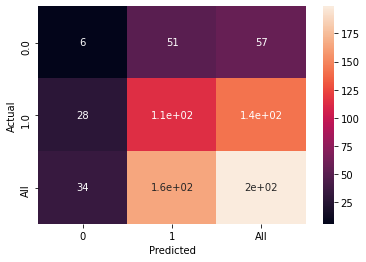

In [76]:

sn.heatmap(confusion_matrix, annot=True)
plt.show()